In [1]:
!pip install optuna

In [2]:
!pip install lime

In [3]:
import pandas as pd
import numpy as np

import copy
import pickle
from datetime import datetime

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import median_absolute_error as MAPE
from sklearn.metrics import r2_score  as R2
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score

# Parameter tunning
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt 

import optuna

import lime
import lime.lime_tabular

from google.colab import drive
%matplotlib inline

Version: 1

Data description:
- 1127 postcodes
- Google POI + EPC statistics + Property Data

Goal: Rents

In [4]:
# Execute this cell paste the Key, and press the key ENTER...
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
Data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Ben/datasetV7.csv') 


In [6]:
Data.isna().sum().sort_values(ascending=False).head(15)

cemetery_min              631
police_min                520
hindu_temple_min          445
fire_station_min          259
mosque_min                 67
Population                 56
Households                 56
shopping_mall_min          44
hospital_min               16
area_std                    5
construction_1991_1995      0
construction_2007_2011      0
construction_2003_2006      0
construction_1996_2002      0
construction_1983_1990      0
dtype: int64

In [7]:
Data['cemetery_min'] = Data['cemetery_min'].replace(np.nan, 2000)
Data['police_min'] = Data['police_min'].replace(np.nan, 2000)
Data['hindu_temple_min'] = Data['hindu_temple_min'].replace(np.nan, 2000)
Data['fire_station_min'] = Data['fire_station_min'].replace(np.nan, 2000)
Data['mosque_min'] = Data['mosque_min'].replace(np.nan, 2000)
Data['shopping_mall_min'] = Data['shopping_mall_min'].replace(np.nan, 2000)
Data['hospital_min'] = Data['hospital_min'].replace(np.nan, 2000)

In [8]:
Data['area_std'] = Data['area_std'].replace(np.nan, -200)
Data['Population'] = Data['Population'].replace(np.nan, -200)
Data['Households'] = Data['Households'].replace(np.nan, -200)

In [9]:
Data.isna().sum().sort_values(ascending=False).head(15)

Unnamed: 0                   0
construction_1950_1966       0
construction_2012_onwards    0
construction_2007_2011       0
construction_2003_2006       0
construction_1996_2002       0
construction_1991_1995       0
construction_1983_1990       0
construction_1976_1982       0
construction_1967_1975       0
construction_1930_1949       0
postcode_Longitude           0
construction_1900_1929       0
construction_before_1900     0
area_std                     0
dtype: int64

In [10]:
list(Data.columns)

['Unnamed: 0',
 'postcode',
 'synagogue_rating_mean_1500',
 'synagogue_rating_std_1500',
 'synagogue_count_1500',
 'synagogue_rating_mean_1000',
 'synagogue_rating_std_1000',
 'synagogue_count_1000',
 'synagogue_rating_mean_500',
 'synagogue_rating_std_500',
 'synagogue_count_500',
 'synagogue_min',
 'shopping_mall_rating_mean_1500',
 'shopping_mall_rating_std_1500',
 'shopping_mall_count_1500',
 'shopping_mall_rating_mean_1000',
 'shopping_mall_rating_std_1000',
 'shopping_mall_count_1000',
 'shopping_mall_rating_mean_500',
 'shopping_mall_rating_std_500',
 'shopping_mall_count_500',
 'shopping_mall_min',
 'secondary_rating_mean_1500',
 'secondary_rating_std_1500',
 'secondary_count_1500',
 'secondary_rating_mean_1000',
 'secondary_rating_std_1000',
 'secondary_count_1000',
 'secondary_rating_mean_500',
 'secondary_rating_std_500',
 'secondary_count_500',
 'secondary_min',
 'school_rating_mean_1500',
 'school_rating_std_1500',
 'school_count_1500',
 'school_rating_mean_1000',
 'school

### Crime

In [11]:
Data['crime_total']=Data['PublicOrder']+Data['Burglary']+Data['Robbery']+Data['PossessionOfWeapons']+Data['BicycleTheft']+Data['AntiSocialBehaviour']+Data['Violence']+Data['Theft']+Data['Shoplifting']+Data['OtherCrime']+Data['Drugs']+Data['OtherTheft']+Data['VehicleCrime']+Data['CriminalDamage']

In [12]:
Data['PublicOrder']=Data['PublicOrder']/Data['crime_total']

In [13]:
Data['Burglary'] = Data['Burglary']/Data['crime_total']
Data['Robbery'] = Data['Robbery']/Data['crime_total']
Data['PossessionOfWeapons'] = Data['PossessionOfWeapons']/Data['crime_total']
Data['BicycleTheft'] = Data['BicycleTheft']/Data['crime_total']
Data['AntiSocialBehaviour'] = Data['AntiSocialBehaviour']/Data['crime_total']
Data['Violence'] = Data['Violence']/Data['crime_total']
Data['Theft'] = Data['Theft']/Data['crime_total']
Data['Shoplifting'] = Data['Shoplifting']/Data['crime_total']
Data['OtherCrime'] = Data['OtherCrime']/Data['crime_total']
Data['Drugs'] = Data['Drugs']/Data['crime_total']
Data['OtherTheft'] = Data['OtherTheft']/Data['crime_total']
Data['VehicleCrime'] = Data['VehicleCrime']/Data['crime_total']
Data['CriminalDamage'] = Data['CriminalDamage']/Data['crime_total']

Data['crime_Type_A'] = Data['Robbery']+Data['Drugs']+Data['PossessionOfWeapons']+Data['Burglary']+Data['OtherCrime']
Data['crime_Type_B'] = Data['OtherTheft'] + Data['Shoplifting'] + Data['Theft'] + Data['BicycleTheft']
Data['crime_Type_C'] = Data['CriminalDamage']+ Data['Violence'] + Data['AntiSocialBehaviour']
Data['crime_Type_D'] = Data['VehicleCrime']

In [14]:
dropList=['Burglary',
 'Robbery',
 'PossessionOfWeapons',
 'BicycleTheft',
 'AntiSocialBehaviour',
 'Violence',
 'Theft',
 'Shoplifting',
 'OtherCrime',
 'Drugs',
 'OtherTheft',
 'VehicleCrime',
 'CriminalDamage',]
Data.drop(dropList, axis = 1, inplace = True)

### Age 

error: age55_59 age65-69

In [15]:
Data['TotalModPop'] = Data['age20_24']+Data['age25_29']+Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age20_29'] = Data['age20_24']+Data['age25_29']
Data['age30_64'] = Data['age30_34']+Data['age35_39']+Data['age40_44']+Data['age45_49']+Data['age50_54']+Data['age60_64']
Data['age65_'] = Data['age70_74']+Data['age75_79']+Data['age80_84']+Data['age85_89']

In [16]:
dropList=['age20_24',
 'age25_29',
 'age30_34',
 'age35_39',
 'age40_44',
 'age45_49',
 'age50_54',
 'age60_64',
 'age70_74',
 'age75_79',
 'age80_84',
 'age85_89']
Data.drop(dropList, axis = 1, inplace = True)

In [17]:
Data['commute_method_public'] = Data['commute_method_train'] + Data['commute_method_bus'] + Data['commute_method_underground_light_rail']
Data['commute_method_private'] = Data['commute_method_motorcycle'] + Data['commute_method_taxi'] + Data['commute_method_car_driver'] + Data['commute_method_car_passenger']
Data['commute_method_open'] = Data['commute_method_foot']+Data['commute_method_bicycle']

In [18]:
dropList=['commute_method_foot',
 'commute_method_bicycle',
 'commute_method_other',
 'commute_method_motorcycle',
 'commute_method_taxi',
 'commute_method_train',
 'commute_method_bus',
 'commute_method_underground_light_rail',
 'commute_method_car_driver',
 'commute_method_at_home',
 'commute_method_car_passenger',
]
Data.drop(dropList, axis = 1, inplace = True)

In [19]:
#Data['sold_70pc_disp']=-(Data['sold_70pc_rangeMIN']-Data['sold_70pc_rangeMAX'])/Data['sold_average']
#Data['sold_80pc_disp']=-(Data['sold_80pc_rangeMIN']-Data['sold_80pc_rangeMAX'])/Data['sold_average']
#Data['sold_90pc_disp']=-(Data['sold_90pc_rangeMIN']-Data['sold_90pc_rangeMAX'])/Data['sold_average']
#Data['sold_100pc_disp']=-(Data['sold_100pc_rangeMIN']-Data['sold_100pc_rangeMAX'])/Data['sold_average']

In [20]:
#Data['sold_sqf_70pc_disp'] =-(Data['sold_sqf_70pc_rangeMIN']-Data['sold_sqf_70pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_80pc_disp'] =-(Data['sold_sqf_80pc_rangeMIN']-Data['sold_sqf_80pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_90pc_disp'] =-(Data['sold_sqf_90pc_rangeMIN']-Data['sold_sqf_90pc_rangeMAX'])/Data['sold_sqf_average']
#Data['sold_sqf_100pc_disp'] =-(Data['sold_sqf_100pc_rangeMIN']-Data['sold_sqf_100pc_rangeMAX'])/Data['sold_sqf_average']

In [21]:
#Data['rents_70pc_disp'] = -(Data['rents_70pc_rangeMIN']-Data['rents_70pc_rangeMAX'])/Data['rents_average']
#Data['rents_80pc_disp'] =-(Data['rents_80pc_rangeMIN']-Data['rents_80pc_rangeMAX'])/Data['rents_average']
#Data['rents_90pc_disp'] =-(Data['rents_90pc_rangeMIN']-Data['rents_90pc_rangeMAX'])/Data['rents_average']
#Data['rents_100pc_disp'] =-(Data['rents_100pc_rangeMIN']-Data['rents_100pc_rangeMAX'])/Data['rents_average']

In [22]:
dropList=[ 'dyn_sold_points_analysed',
 'dyn_sold_70pc_rangeMIN',
 'dyn_sold_70pc_rangeMAX',
 'dyn_sold_80pc_rangeMIN',
 'dyn_sold_80pc_rangeMAX',
 'dyn_sold_90pc_rangeMIN',
 'dyn_sold_90pc_rangeMAX',
 'dyn_sold_sqf_points_analysed',
 'dyn_sold_sqf_70pc_rangeMIN',
 'dyn_sold_sqf_70pc_rangeMAX',
 'dyn_sold_sqf_80pc_rangeMIN',
 'dyn_sold_sqf_80pc_rangeMAX',
 'dyn_sold_sqf_90pc_rangeMIN',
 'dyn_sold_sqf_90pc_rangeMAX',
 'dyn_rents_points_analysed',
 'dyn_rents_70pc_rangeMIN',
 'dyn_rents_70pc_rangeMAX',
 'dyn_rents_80pc_rangeMIN',
 'dyn_rents_80pc_rangeMAX',
 'dyn_rents_90pc_rangeMIN',
 'dyn_rents_90pc_rangeMAX',]
Data.drop(dropList, axis = 1, inplace = True)

In [23]:
### POI 


In [24]:
Data['HousePerPopulation']=Data['Households']/Data['Population']

In [25]:
Data['construction_before_1950']=(Data['construction_before_1900'] + Data['construction_1900_1929'] + Data['construction_1930_1949']) 
Data['construction_1950_1975']=(Data['construction_1950_1966']+Data['construction_1967_1975']+ Data['construction_1976_1982'])
Data['construction_1983_1990']=(Data['construction_1983_1990']+Data['construction_1991_1995'])
Data['construction_1996_2006']=(Data['construction_1996_2002']+Data['construction_2003_2006'])
Data['construction_2007_onwards']=(Data['construction_2007_2011']+Data['construction_2012_onwards'])

In [26]:
dropList=['construction_before_1900',
 'construction_1900_1929',
 'construction_1930_1949',
 'construction_1950_1966',
 'construction_1967_1975',
 'construction_1976_1982',
 'construction_1983_1990',
 'construction_1991_1995',
 'construction_1996_2002',
 'construction_2003_2006',
 'construction_2007_2011',
 'construction_2012_onwards']
Data.drop(dropList, axis = 1, inplace = True)

In [27]:
Data.isna().sum().sort_values(ascending=False).head(15)

Unnamed: 0                    0
bars_price_level_std_500      0
bars_rating_std_500           0
bars_rating_mean_500          0
bars_count_1000               0
bars_price_level_std_1000     0
bars_price_level_mean_1000    0
bars_rating_std_1000          0
bars_rating_mean_1000         0
bars_count_1500               0
bars_price_level_std_1500     0
bars_price_level_mean_1500    0
bars_rating_std_1500          0
bars_rating_mean_1500         0
subway_station_min            0
dtype: int64

Removing inrelevant attributes

In [28]:
dropList=['Unnamed: 0','postcode','count',
         'postcode_Latitude','postcode_Longitude','MSOA_Code','LSOA_Code','area'
          ]
Data.drop(dropList, axis = 1, inplace = True)

In [29]:
dropList=['dyn_sold_average',
 'dyn_sold_100pc_rangeMIN',
 'dyn_sold_100pc_rangeMAX',
 'dyn_sold_sqf_100pc_rangeMIN',
 'dyn_sold_sqf_100pc_rangeMAX',
 'dyn_sold_sqf_average',
 'dyn_rents_100pc_rangeMIN',
 'dyn_rents_100pc_rangeMAX',
         ]
Data.drop(dropList, axis = 1, inplace = True)

Adding the rental price by sq

### Rental price statistics

In [30]:
Data['dyn_rents_average'].describe()

count    1127.000000
mean      409.968944
std        67.114718
min       299.000000
25%       358.500000
50%       401.000000
75%       453.000000
max       757.000000
Name: dyn_rents_average, dtype: float64

No handles with labels found to put in legend.


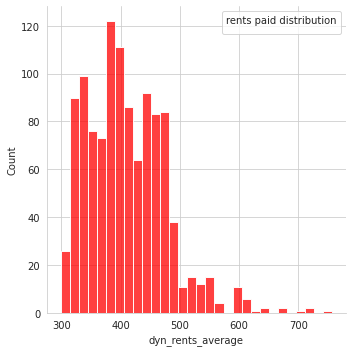

In [31]:
sns.set_style('whitegrid')
sns.displot(Data[ 'dyn_rents_average'], kde = False, color ='red', bins = 30)
plt.legend(title='rents paid distribution')

### Categorical attribute binarization

In [32]:

catData = ['dyn_ptal', 'dyn_flood_risk','crime_rating']
for att in catData:
    unique_classes = Data[att].unique()
    one_hot = pd.get_dummies(unique_classes, prefix=att,dummy_na=True, columns = [att])
    one_hot[att] = unique_classes
    Data = Data.merge(one_hot, on = [att], how='left')
    Data = Data.drop(columns = [att])

In [33]:
list(Data.columns)

['synagogue_rating_mean_1500',
 'synagogue_rating_std_1500',
 'synagogue_count_1500',
 'synagogue_rating_mean_1000',
 'synagogue_rating_std_1000',
 'synagogue_count_1000',
 'synagogue_rating_mean_500',
 'synagogue_rating_std_500',
 'synagogue_count_500',
 'synagogue_min',
 'shopping_mall_rating_mean_1500',
 'shopping_mall_rating_std_1500',
 'shopping_mall_count_1500',
 'shopping_mall_rating_mean_1000',
 'shopping_mall_rating_std_1000',
 'shopping_mall_count_1000',
 'shopping_mall_rating_mean_500',
 'shopping_mall_rating_std_500',
 'shopping_mall_count_500',
 'shopping_mall_min',
 'secondary_rating_mean_1500',
 'secondary_rating_std_1500',
 'secondary_count_1500',
 'secondary_rating_mean_1000',
 'secondary_rating_std_1000',
 'secondary_count_1000',
 'secondary_rating_mean_500',
 'secondary_rating_std_500',
 'secondary_count_500',
 'secondary_min',
 'school_rating_mean_1500',
 'school_rating_std_1500',
 'school_count_1500',
 'school_rating_mean_1000',
 'school_rating_std_1000',
 'school_

### Define rental price as the model goal 

In [34]:
Data['price'] = Data['dyn_rents_average']
Data.drop(['dyn_rents_average'], axis = 1, inplace = True)

In [35]:
# Split data: X,y
X, y = Data.iloc[:, :-1], Data.iloc[:, -1]

### Model tunning


In [36]:
xxx

NameError: ignored

In [ ]:
def objective(trial, X, y, kf):

    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

    rf_n_estimators = trial.suggest_categorical('rf_n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('rf_max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('rf_max_samples', 0.6, 0.99)
      
    classifier_obj = RandomForestRegressor(n_estimators=rf_n_estimators,
                      max_features=rf_max_features, min_samples_split=rf_min_samples_split,
                      min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
                      bootstrap=True, n_jobs=-1, verbose=0)
    
    
    test_score = []
    
    step = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        test_score.append(MAE(y_test, y_pred)/409.968*100)
        #test_score.append(R2(y_test, y_pred))
        
        trial.report(np.mean(test_score), step)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        step+=1

    return np.mean(test_score)



kf = KFold(n_splits=4, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize',
                            pruner=optuna.pruners.SuccessiveHalvingPruner())

study.optimize(lambda trial: objective(trial, X, y, kf), timeout=30*60, n_jobs=1)

study.best_params 

In [37]:
n_estimators=75
max_features=0.710
min_samples_split=9
min_samples_leaf=6
max_samples=0.722

In [38]:
# Splitting Train/Test
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

### Model

In [39]:
# Splitting Train/Test
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.2)

In [40]:
model = RandomForestRegressor(n_estimators=n_estimators,
        max_features=max_features, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, max_samples=max_samples,
        bootstrap=True, n_jobs=-1, verbose=0)

model.fit(train_X, train_y)

print(f'model score on training data: {model.score(train_X, train_y)}')
print(f'model score on testing data: {model.score(test_X, test_y)}')

model score on training data: 0.9686394918216912
model score on testing data: 0.9497726550091787


model score on training data: 0.9648069689238171
model score on testing data: 0.9467969456245727

model score on training data: 0.9927387911409788
model score on testing data: 0.9601407098621033

In [44]:
abs(test_y-model.predict(test_X))/409.968*100

145     1.520505
276     0.026095
1099    0.756468
21      1.263105
719     1.210258
          ...   
705     1.566718
765     0.388620
522     0.027335
1071    0.957293
760     1.411883
Name: price, Length: 226, dtype: float64

No handles with labels found to put in legend.


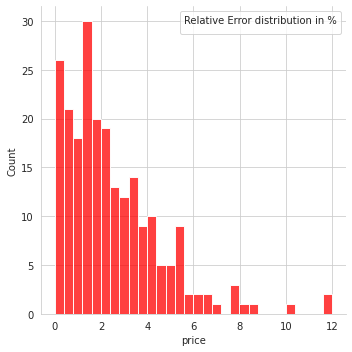

In [48]:
sns.set_style('whitegrid')
sns.displot( abs(test_y-model.predict(test_X))/test_y*100, kde = False, color ='red', bins = 30)
plt.legend(title='Relative Error distribution in %')

In [49]:
explainer = lime.lime_tabular.LimeTabularExplainer(train_X.values,feature_names=train_X.columns,   verbose=True, mode='regression')

In [50]:
i = 25 # Item Idx used to test explainer
exp = explainer.explain_instance(test_X.iloc[i].values, model.predict, num_features=50)

Intercept 468.8015211317789
Prediction_local [397.05212309]
Right: 393.0285202020202


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


## List with conditions and importance

In [51]:
exp.as_list()

[('0.86 < restaurants_price_level_mean_1500 <= 0.98', -24.462475359916656),
 ('0.10 < subway_station_rating_std_1500 <= 0.21', 19.358469909069015),
 ('synagogue_rating_std_500 <= 0.00', -12.263962050167038),
 ('dyn_flood_risk_Low <= 0.00', -8.043411748292984),
 ('4.70 < mosque_rating_mean_1000 <= 4.80', -7.989507954451423),
 ('police_rating_std_500 <= 0.00', -6.864566946598305),
 ('dyn_flood_risk_Medium <= 0.00', -5.284601763854646),
 ('crime_rating_Very high crime <= 0.00', -4.7746673052477995),
 ('bars_count_1500 > 88.00', 3.9986178008897215),
 ('train_station_rating_std_500 <= 0.00', -3.8349910346251552),
 ('crime_rating_High crime <= 0.00', -3.4724242873693973),
 ('0.56 < bars_rating_std_1500 <= 0.76', -3.27879069689437),
 ('dyn_ptal_1b <= 0.00', -3.175566426875392),
 ('mosque_rating_std_500 <= 0.00', 3.1230241269421852),
 ('train_station_count_500 <= 0.00', 2.934476607911708),
 ('subway_station_rating_std_500 <= 0.00', 2.907210235221929),
 ('0.66 < cafe_price_level_mean_1500 <= 0.

## Save to HTML

In [52]:
exp.save_to_file('/content/drive/My Drive/Colab Notebooks/Ben/test.html',show_table=True)

### Show table

In [53]:
exp.show_in_notebook(show_table=True)

Cross validation

In [54]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
# MAE Computation
print("Train MAE : " ,scores.mean()/409.968944*100," % --- std ",scores.std())

Train MAE :  2.5926210007347565  % --- std  1.0181866838860738


default parameters  -- Train MAE :  2.343527260000697  % --- std  0.7848069502633133

## Feature importance

In [55]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

In [56]:
for curr_feat in train_X.columns:
  feature_importance = get_feature_importance(model, train_X, train_y, curr_feat)
  print(f'feature importance of "{curr_feat}" on train set is '
        f'{feature_importance:.3}')

feature importance of "synagogue_rating_mean_1500" on train set is 0.0
feature importance of "synagogue_rating_std_1500" on train set is 0.0
feature importance of "synagogue_count_1500" on train set is 0.0
feature importance of "synagogue_rating_mean_1000" on train set is 0.0
feature importance of "synagogue_rating_std_1000" on train set is 0.0
feature importance of "synagogue_count_1000" on train set is 6.38e-05
feature importance of "synagogue_rating_mean_500" on train set is 6.23e-06
feature importance of "synagogue_rating_std_500" on train set is 0.0
feature importance of "synagogue_count_500" on train set is 0.0
feature importance of "synagogue_min" on train set is 0.00111
feature importance of "shopping_mall_rating_mean_1500" on train set is 0.000142
feature importance of "shopping_mall_rating_std_1500" on train set is 0.000723
feature importance of "shopping_mall_count_1500" on train set is 0.000492
feature importance of "shopping_mall_rating_mean_1000" on train set is 3.9e-05
f

Since there are some randomness, it is advice to run multiple times and inspect the mean and the standard deviation of the feature importance

In [57]:
n_repeats = 10
for curr_feat in train_X.columns:
  list_feature_importance = []
  for n_round in range(n_repeats):
      list_feature_importance.append(
          get_feature_importance(model, train_X, train_y, curr_feat))

  print(
      f'feature importance of "{curr_feat}" on train set is '
      f'{np.mean(list_feature_importance):.3} '
      f'+/- {np.std(list_feature_importance):.3}')

feature importance of "synagogue_rating_mean_1500" on train set is 0.0 +/- 0.0
feature importance of "synagogue_rating_std_1500" on train set is 0.0 +/- 0.0
feature importance of "synagogue_count_1500" on train set is 0.0 +/- 0.0
feature importance of "synagogue_rating_mean_1000" on train set is 0.0 +/- 0.0
feature importance of "synagogue_rating_std_1000" on train set is 0.0 +/- 0.0
feature importance of "synagogue_count_1000" on train set is 6e-05 +/- 4.69e-06
feature importance of "synagogue_rating_mean_500" on train set is 6.1e-06 +/- 3.11e-07
feature importance of "synagogue_rating_std_500" on train set is 0.0 +/- 0.0
feature importance of "synagogue_count_500" on train set is 0.0 +/- 0.0
feature importance of "synagogue_min" on train set is 0.00111 +/- 9.17e-05
feature importance of "shopping_mall_rating_mean_1500" on train set is 0.00014 +/- 4.83e-05
feature importance of "shopping_mall_rating_std_1500" on train set is 0.000712 +/- 0.000181
feature importance of "shopping_mall_c

## The feature permutation importance 

In [58]:
def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

# This function could directly be access from sklearn
# from sklearn.inspection import permutation_importance

In [59]:
def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(1, 1, figsize=(17,50))
    
    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

In [60]:
perm_importance_result_train = permutation_importance(model, train_X, train_y, n_repeats=10)


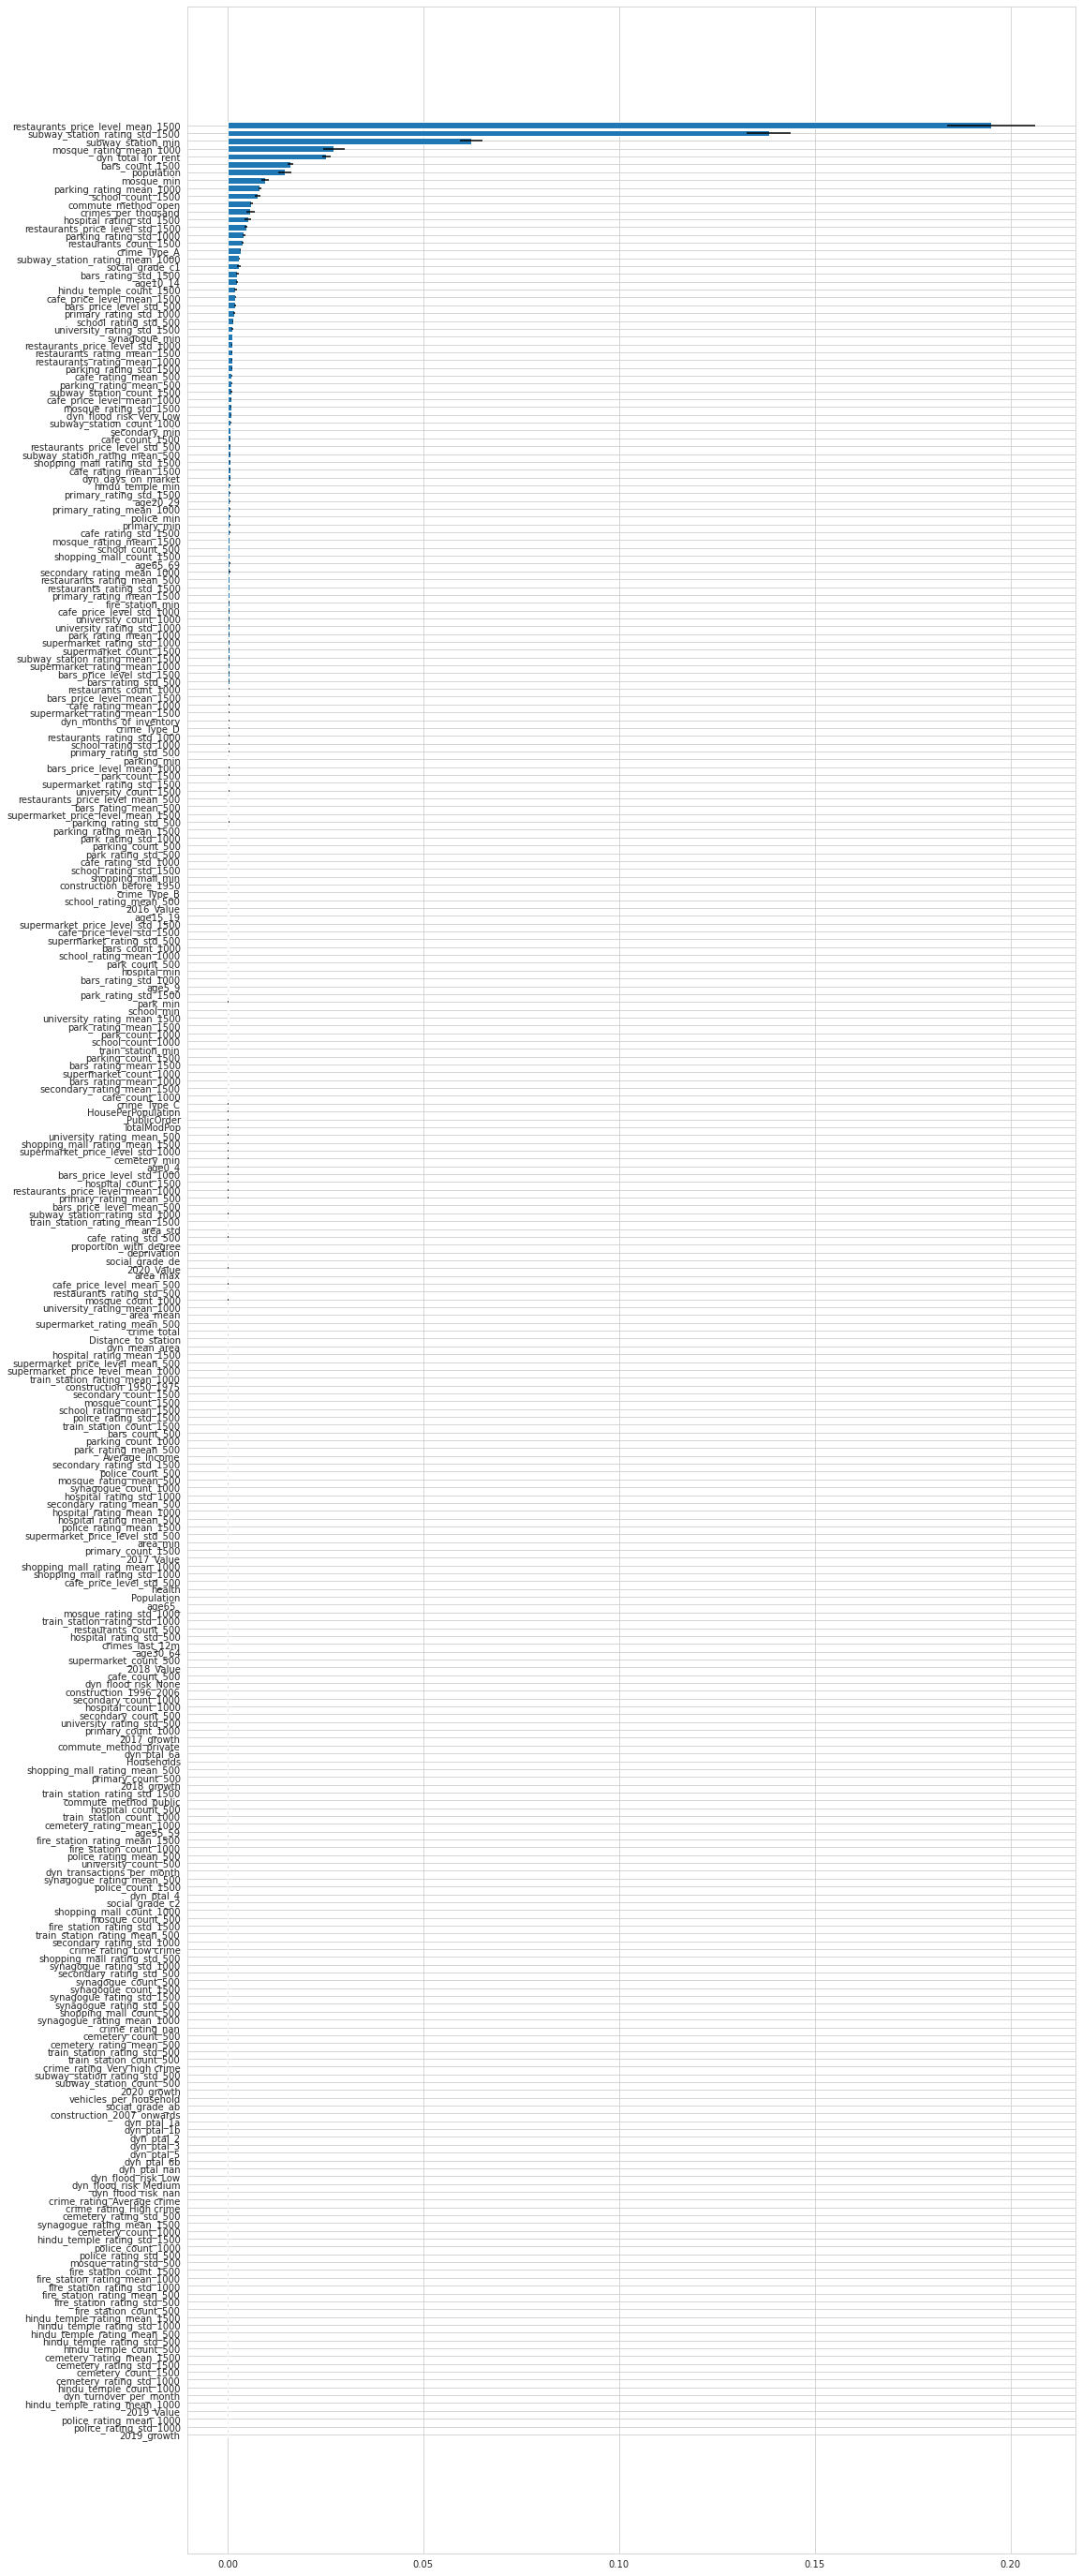

In [61]:
plot_importantes_features(perm_importance_result_train, train_X.columns)